In [1]:
import numpy as np
import cvxopt as cvx
import matplotlib
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
matplotlib.rcParams['figure.figsize'] = (4, 4)

### define some constants

In [2]:
g=9.8     #gravity on earth
A0 = 0.01 #unit section of a bar (in m2)
D = 450.  #density of the bar (kg/m3)
E = 9 #young elasticity modulus (in GPa) --> so u = K^-1 f is in nm

#### This function returns the variables `nodes` (coordinate of truss nodes),`bars` (list of pairs of nodes), and `dofs` ({0,1}-array of the same size as `nodes`, which indicates the degrees of freedom of the truss).

In [3]:
def small_structure():
    nodes = np.array([
    [0,1],#node 0
    [1,1],#node 1
    [0,0],#node 2
    [1,0],#node 3
    [2,0],#node 4
    ])

    dofs = np.array([
        [0,0],#node 0 does not move
        [1,1],#node 1 is free
        [0,1],#node 2 can move vertically
        [1,1],#node 3 is free
        [1,1],#node 4 is free
        ])

    bars = [[0,1],
            [0,2],
            [1,2],
            [2,3],
            [1,3],
            [1,4],
            [3,4]]
    return nodes,dofs,bars


The function `stiffness_vectors` returns the list of vectors $\boldsymbol{v}_i$'s such that the stiffness matrix is equal to $\sum_i x_i \boldsymbol{v}_i \boldsymbol{v}_i^ T$, where $x_i$ is the scaling factor of bar $i$.

The function `stiffness_matrix(x)` returns the matrix $\sum_i x_i \boldsymbol{v}_i \boldsymbol{v}_i^ T$.

In [4]:
def stiffness_vectors():
    v = []
    n = len(nodes)
    m = len(bars)
    d = nodes.shape[1]
    dof_mask = np.concatenate(dofs,axis=0)
    for k,(i,j) in enumerate(bars):
        L = np.linalg.norm(nodes[i]-nodes[j])
        angles = (nodes[j]-nodes[i])/L
        vk = np.array([0.]*d*n)
        vk[d*i:d*(i+1)] = angles
        vk[d*j:d*(j+1)] = -angles
        vk *= (E*A0/L)**0.5
        v.append(cvx.matrix(vk[dof_mask==1]))
    return v
            
def stiffness_matrix(x=None):
    n = len(bars)
    if x is None:
        x=[1]*n
    v = stiffness_vectors()
    m = len(v[0])
    K = cvx.matrix(0,(m,m))
    for i in range(n):
        K = K + x[i]*v[i]*v[i].T
    return K

This function draws the truss (defined in global vars `nodes`,`dofs`
and `bars`), with bar widths `x`, and if a force vector `f` is provided, the displacement of the structure, amplified by a factor `delta`.

In [5]:
def draw_truss(x=None,f=None, delta = 1.):
    if x is None:
        x=[1]*len(bars)
    for k,(i,j) in enumerate(bars):
        plt.plot([nodes[i][0],nodes[j][0]],[nodes[i][1],nodes[j][1]],linewidth = 3*x[k],color='blue')
    
    minx,miny = np.min(nodes,axis=0)
    maxx,maxy = np.max(nodes,axis=0)
    plt.xlim(minx-0.2,maxx+0.2)
    plt.ylim(miny-0.2,maxy+.2)
    
    if f is not None:
        K = stiffness_matrix(x=x)
        dof_mask = np.concatenate(dofs,axis=0)
        ff = f.ravel()[dof_mask==1] #projection on coordinates of the degrees of freedom
        dx = np.zeros(nodes.shape[0]*nodes.shape[1])
        dx[dof_mask==1] = np.linalg.lstsq(K,ff)[0]*1e-9 #1e-9 because E is in GPa
        dx= np.reshape(dx,nodes.shape)
        dnodes = nodes + delta * dx
        for k,(i,j) in enumerate(bars):
            plt.plot([dnodes[i][0],dnodes[j][0]],[dnodes[i][1],dnodes[j][1]],linewidth = 3*x[k],color='red')

### OK, let's draw the truss

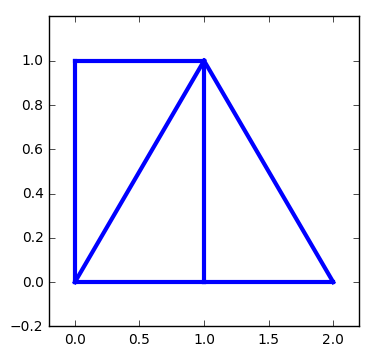

In [6]:
nodes,dofs,bars = small_structure()
draw_truss()

### Now, we apply a force and we display the displacements

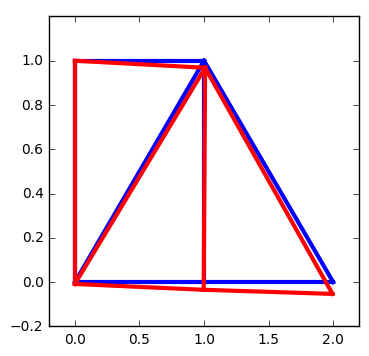

In [7]:
#we define a force f that puts 500 kg on the 3 nodes below.
#note that according to `nodes` and `dofs`, this corresponds to the
#3rd, 5th, and 7th degrees of freedom.
f = np.array([
     [0,0],
     [0,0],
     [0,-g*500],# 500kg vertically on node 2
     [0,-g*500],# 500kg vertically on node 3
     [0,-g*500],# 500kg vertically on node 4
     ])
draw_truss(f=f,delta=50)

### Now, a function to make the structure of a crane

The function takes as arguments the total height and width of the crane,
the height `cr` of the top part of the crane, and the
maximum length of considered cross bars (1,2,or 3).

The function further returns a force vector `F` (whose dimension cooresponds
to the number of degrees of freedom of the structure), such that a force
of coordinate (`ff[0],ff[1]`) is applied to the extremity of the crane.

In [8]:
def crane_structure(cr=2,height=8,width=8,max_len=2,ff=(-500,-1000)):
    nodes = []
    for i in range(width):
        for j in range(height):
            if j>=height-cr-1 or i==2 or i==3:
                nodes.append((i,j))

    nodes = np.array(nodes) 

    dofs = np.ones(nodes.shape)
    dofs[:,0][nodes[:,1]==0]=0
    dofs[:,1][nodes[:,1]==0]=0

    n = len(nodes)
    bars = []
    for i in range(n):
        for j in range(n):
            if i<j and np.linalg.norm(nodes[i]-nodes[j])<1.5:
                bars.append([i,j])
            if max_len>=2 and i<j and np.linalg.norm(nodes[i]-nodes[j])==5**0.5:
                bars.append([i,j])
            if max_len>=3 and i<j and np.linalg.norm(nodes[i]-nodes[j])==10**0.5:
                bars.append([i,j])
                
    F = np.zeros((n,2))
    F[n-1-cr,0]=g*ff[0]
    F[n-1-cr,1]=g*ff[1]

    return nodes,dofs,bars,F

### We are going to optimize the truss, subject to a constraint on the total volume of all bars: $\sum_i x_i L_i \leq W:= \frac{V}{A_0}$
### We first draw the crane for a "uniform" solution

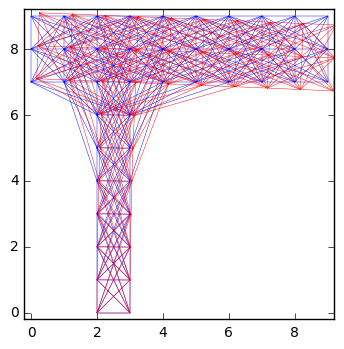

In [9]:
nodes,dofs,bars,F = crane_structure(cr=2,height=10,width=10,max_len=3,ff=(-500,-1000))
Lbars = [np.linalg.norm(nodes[i]-nodes[j]) for i,j in bars]
n,m = len(nodes),len(bars)
W = 50

x = [1./sum(Lbars)*W]*m
draw_truss(x=x,f=F)

### Now, formulate an SDP to minimize the compliance $\boldsymbol{f}^T K^{-1} \boldsymbol{f}$ of the crane.

In [ ]:
import picos as pic
n = len(nodes)
m = len(bars)
LL = pic.new_param('LL',Lbars)
dof_mask = np.concatenate(dofs,axis=0)
f = F.ravel()[dof_mask==1]   #project force on coordinates of degrees of freedom
f = pic.new_param('f',f/1e6) #divide by 1e6 for the sake of numerical accuracy

P = pic.Problem()
x = P.add_variable('x',m,lower=0)
#define the stiffness matrix (note: this is a linear expression w.r.t. x)
K = stiffness_matrix(x)

#TODO add other variables, constraints, and objective...
P.solve()

draw_truss(x=x.value,f=F)

### In fact, we showed in the tutorial session that this problem can also be formulated as an SOCP. Implement it here

In [ ]:
P = pic.Problem()
v = stiffness_vectors()
A = pic.new_param('A',cvx.matrix([vi.T for vi in v]).T)

x = P.add_variable('x',m,lower=0)
#TODO add other variables, constraints, and objective...

P.solve(solver='mosek',handleConeVars=False,verbose=False)
draw_truss(x=x.value,f=F)

### Now, formulate an SDP to the problem of minimize the worst case compliance  $f^TK^{−1}f$, over the set of all force vectors $f$ such that $\Vert f \Vert_2 \leq 1$.

In [ ]:
#identity matrix
I = pic.new_param('I',np.eye(K.size[0]))


P = pic.Problem()
x = P.add_variable('x',m,lower=0)

#define the stiffness matrix (note: this is a linear expression w.r.t. x)
K = stiffness_matrix(x)

#TODO add other variables, constraints, and objective...
P.solve(verbose=False)

draw_truss(x=x.value)

### A somewhat more realistic load model is that of a force f acting in an unknown direction, but only at the extremity of the crane. Formulate an SDP in this case.

In [ ]:
#This are the indices of the degrees of freedom at the extremity of the crane
i0 = np.where(np.array(f.value)!=0)[0]

P = pic.Problem()
x = P.add_variable('x',m,lower=0)

#define the stiffness matrix (note: this is a linear expression w.r.t. x)
K = stiffness_matrix(x)

#TODO add other variables, constraints, and objective...
P.solve(verbose=False)

draw_truss(x=x.value)